# What are the common activities that the victims were engaged in prior to the accident?

In [22]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Sep 23 15:12:27 2017

@author: leeto
"""
import os
import json
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize, FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder
from nltk.metrics import BigramAssocMeasures, TrigramAssocMeasures
from nltk.util import ngrams
from nltk.tag.util import *
import wordcloud
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import xlsxwriter

# List Of Category indexes as per stated in the CA document

In [23]:
CategoryIndexes = {"Caught in/between Objects":0,
                     "Falls":1,
                     "Drowning":2,
                     "Other":3,
                     "Others":3,
                     "Struck By Moving Objects":4,
                     "Collapse of object":5,
                     "Fires and Explosion":6,
                     "Electrocution":7,
                     "Suffocation":8,
                     "Exposure to Chemical Substances":9,
                     "Exposure to extreme temperatures":10,
                     }
CategoryNames = {0:"Caught in/between Objects",
                     1:"Falls",
                     2:"Drowning",
                     3:"Other",
                     4:"Struck By Moving Objects",
                     5:"Collapse of object",
                     6:"Fires and Explosion",
                     7:"Electrocution",
                     8:"Suffocation",
                     9:"Exposure to Chemical Substances",
                     10:"Exposure to extreme temperatures",
                     }

# Classes to store the category and case items together with helper functions

In [24]:
def GetCategoryIndex(Name):
    if Name in CategoryIndexes:
        return CategoryIndexes[Name]
    else:
        return -1
    
def GetCategoryName(Index):
    if (Index in CategoryNames):
        return CategoryNames[Index]
    else:
        return "Invalid Category"
        
#Classes To Be Used 
class Category(object):
    def __init__(self, Name, Index):
        self.Name = Name
        self.Index = Index
        self.ActivityTokensChunk = []
        self.ActivityTokensVerb = []
        
    def __str__(self):
        return("Category Item:\n"
               "  Name = {0}({1})\n"
               "  ActivityVerb = {2}\n"
               "  ActivityChunk = {3}\n"
               .format(self.Name, self.Index, str(len(self.ActivityTokensVerb)) , str(len(self.ActivityTokensChunk))))
        
class CaseItem(object):
    def __init__(self, Title, Summary, CauseName, CauseIndex):
        self.CauseName = CauseName
        self.CauseIndex = CauseIndex
        self.Title = Title
        self.Summary = Summary
        self.ActivityTokensChunk = []
        self.ActivityTokensVerb = []

    def __str__(self):
        return("Case Item:\n"
               "  Cause = {0}({1})\n"
               "  Title = {2}\n"
               "  Summary = {3}\n"
               .format(self.CauseName, self.CauseIndex, self.Title, self.Summary))

# Read from and write to excel, populate case items, intialization of categories

In [25]:
#read from excel, populate case items
def ReadFromExcelAndPopulateCase():
    global MsiaCaseItems 
    global OshaCaseItems
    global OshaCasesDF
    global MsiaCasesDF
    MsiaCaseItems = []
    OshaCaseItems = []
    MsiaCasesDF=pd.read_excel(MsiaCasesFile,sheetname=0)
    OshaCasesDF=pd.read_excel(OshaCasesFile,sheetname=0)
    MsiaCasesDF.groupby('Cause ').describe()
    # For each row in the column,
    for index,row in MsiaCasesDF.iterrows():
        TempCaseItem = CaseItem(row['Title Case'], row['Summary Case'], row['Cause '], GetCategoryIndex(row['Cause ']))
        MsiaCaseItems.append(TempCaseItem)
    # For each row in the column,
    for index,row in OshaCasesDF.iterrows():
        TempCaseItem = CaseItem(row['Title'], row['Summary'], row['Cause'], GetCategoryIndex(row['Cause']))
        OshaCaseItems.append(TempCaseItem)

#Initialize Categories array
def InitializeCategories():
    global MsiaCategories
    global OshaCategories
    MsiaCategories = []
    OshaCategories = []
    for index in CategoryNames:
        tempcat = Category(GetCategoryName(index),index)
        MsiaCategories.append(tempcat)
        OshaCategories.append(tempcat)
        
def write_to_file(filename, text):
    f = open(filename, 'a')
    f.write(text + '\n')  # python will convert \n to os.linesep
    f.close()  # you can omit in most cases as the destructor will call it
    
def WriteToExcel(filename, SelectedCaseItemsDF):
    # Create a Pandas Excel writer using XlsxWriter as the engine.
    writer = pd.ExcelWriter(filename, engine='xlsxwriter')
    # Convert the dataframe to an XlsxWriter Excel object.
    SelectedCaseItemsDF.to_excel(writer, sheet_name='Sheet1')
    # Close the Pandas Excel writer and output the Excel file.
    writer.save()    

# Visualisation function to plot frequency distribution, word cloud and list some of the common activities

In [26]:
# Visualisation function to plot frequency distribution, word cloud and list some of the common activities
def Visualisation(category):   
    #tokens = word_tokenize(text)
    if (len(category.ActivityTokensVerb)>0):
        # frequecy distribution chart
        print(category.Name)
        #tokens_clean = [ t for t in category.ActivityTokensVerb if len(t) >= 3 ]
        tokens_clean_single = []
        for tok1 in category.ActivityTokensVerb:
            for tok2 in tok1:
                tokens_clean_single.append(tok2)
        fd = nltk.FreqDist(tokens_clean_single)
        fd.most_common(25)
        TopActivityTokens = fd.most_common(3)
        fd.plot(25)
        #print(tokens_clean_single)
        #print(TopActivityTokens)
        
        # ==== Installation of wordcloud package
        # 1. download wordcloud‑1.3.2‑cp36‑cp36m‑win_amd64.whl from http://www.lfd.uci.edu/~gohlke/pythonlibs/#wordcloud 
        # 2. Copy the file to your current working directory
        # 3. Open command prompt from Tools
        # 4. python -m pip install wordcloud-1.3.2-cp36-cp36m-win_amd64.whl
    
        # 1. Simple cloud
        # Generate a word cloud image
        # Take note that this function requires text string as input
        # text = "".join([' '+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()
        wc = WordCloud(background_color="white")
        wc.generate_from_frequencies(fd)
        # Display the generated image:
        # the matplotlib way:
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        plt.show()    
        
        chunks_limit = 10
        print("Top 3 activity word and their sentences")
        print("=======================================\n")
        for word in TopActivityTokens:
            chunks_count = 0
            underline = ""
            print('\n' + word[0])
            for c in word[0]:
                underline += '='
            print(underline + '\n')
            #Populate sentences belonging to top tokens
            for chunk1 in category.ActivityTokensChunk:
                for chunk2 in chunk1:
                    chunk_token = nltk.sent_tokenize(chunk2)
                    chunk_lemma_token = get_lemma(chunk_token)
                    #print(chunk_lemma_token)
                    #chunk_text = ' '.join(chunk)
                    if len(chunk_lemma_token) >= 1:
                        #print (chunk_lemma_token)
                        for token in chunk_lemma_token:
                            if word[0] in get_lemma_word(token.split(' ')[0]):
                                if (chunks_count < 10):
                                    print(chunk2)
                                chunks_count += 1

            print("\n")
    else:
        print("Visualisation Function : NO DATA AVAILABLE")



# Text Mining helper functions 
- get_lemma - lemmatizer to get the base word based on speech tag
- get_stem - similar to get_lemma but some of the base words are not correct, so I did not use this
- get_verb_count - returns number of verb word found in the sentence
- filter_off_unwanted chunks - custom filter to more accurately extract verb associated with the activities

In [60]:
def get_lemma(subtree):        
    return [ WNlemma.lemmatize(t, 'v') for t in subtree ]

def get_lemma_word(text):
    return WNlemma.lemmatize(text, 'v')

def get_stem(subtree):
    return [ Stemmer.stem(t) for t in subtree ]

def get_verb_count(subtree):
    verb_count = 0
    tokens = nltk.pos_tag(word_tokenize(str(subtree))) 
    for tok in tokens:
        if ('\'VBG\'' in str(tok)) or ('\'VB\'' in str(tok)):
            verb_count += 1
    return verb_count

def filter_off_unwanted_chunks(subtree):
    # first words : crashing, causing, involving, doing, being, falling
    filter_first_words = ['crash', 'cause', 'involve', 'do', 'be', 'fall', 'avoid', 'result', 'address', 'have']
    filter_all_words = ['carry out work', 'fly object']
    filter_last_words = ['victim', 'work']
    filter_short_words = ['kill','carry', 'perform']   
    for ffw in filter_first_words:
        if (ffw in get_lemma(untag(subtree))[0]):
            return False, subtree
    for flw in filter_last_words:
        if (flw in get_lemma(untag(subtree))[len(subtree)-1]):
            return False, subtree
    for fsw in filter_short_words:
        if ( fsw in ' '.join(get_lemma(untag(subtree))) and (len(subtree)<=2) ):
            return False,subtree
    for faw in filter_all_words:
        if ( faw in ' '.join(get_lemma(untag(subtree))) ):
            print (faw)
            return False, subtree
    if get_verb_count(untag(subtree)) > 0:  
        return True, subtree
    else: 
        return False, subtree

def clean_up_chunk(text):
    text = text.replace("carri", "carry")
    text = text.replace("[","").replace("]","").replace("\'","").replace("\"","")
    text = text.replace("\'","").replace("\"","").replace(",","")
    return text

def clean_up_verb(text):
    text = text.replace("carri", "carry")
    text = text.replace("[","").replace("]","").replace("\'","").replace("\"","")
    text = text.replace("\'","").replace("\"","").replace(",","")
    text = text.replace(' ','')
    return text

# Main function to extract the activities sentences and verb
- 1st loop (ie. OCC1) is used for extracting the sentences containing the activities. The RegexpParser will look for verb in past tenses(VBD), base form(VB), past participle(VBN), present participle(VBG) etc that is constructed together with nouns(singular, plural, proper noun,) as well as preposition(IN), adjective(JJ), particle(PR).

- 2nd loop (ie. OCC2) is used to further extract the base verb that is found using OCC1.

In [61]:
def extract_activities_chunk_and_verb(text):
    chunk_grammar = r"""
        OCC1:{<VBG|VB>+<IN|DT|JJ|RP>*<NN|NN.*>+(<IN|DT|JJ|RP>*<VBG|VB>+<NN|NN.*>+)?}
    """

    verb_grammar = r"""
        OCC2:{<VBG|VB>+}
    """    
#   original OCC:{<VBG|VB>+<IN|DT|JJ|RP>?<NN|NN.*>+<VBG|VB>?}
    ExtractedActivitiesChunk = []
    ExtractedActivitiesVerb = []
    if (not text=="") and (len(text) >= 3):
        chunk_parser = nltk.RegexpParser(chunk_grammar)
        tokens_chunk = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
        tagged_chunk = nltk.pos_tag(tokens_chunk)
        if (len(tagged_chunk) > 0):
            extract_chunk = chunk_parser.parse(tagged_chunk)
            for subtree_chunk in extract_chunk.subtrees(filter=lambda t: 'OCC1' in t.label()):  
                acceptChunk, processed_subtree_chunk = filter_off_unwanted_chunks(subtree_chunk)
                if (acceptChunk == True):
                    token_chunk_clean = untag(processed_subtree_chunk)
                    #token_chunk_clean_str = clean_up_chunk(str(get_lemma(token_chunk_clean)))
                    token_chunk_clean_str = clean_up_chunk(str(token_chunk_clean))
                    print(token_chunk_clean_str + "(" + str(get_verb_count(untag(processed_subtree_chunk))) + ")")
                    ExtractedActivitiesChunk.append(token_chunk_clean_str)
                    verb_parser = nltk.RegexpParser(verb_grammar)
                    tokens_verb = [word for sent in nltk.sent_tokenize(token_chunk_clean_str) for word in nltk.word_tokenize(sent)]
                    tagged_verb = nltk.pos_tag(tokens_verb)
                    if (len(tagged_verb) > 0):
                        extract_verbs = verb_parser.parse(tagged_verb)
                        for subtree_verb in extract_verbs.subtrees(filter=lambda t: 'OCC2' in t.label()):  
                            #print(subtree_verb)
                            tokens_verb_lem = get_lemma(untag(subtree_verb))   
                            tokens_verb_lem_clean = clean_up_verb(str(tokens_verb_lem))
                            #print(tokens_verb_lem_clean)
                            ExtractedActivitiesVerb.append(clean_up_verb(str(tokens_verb_lem_clean)))
    return ExtractedActivitiesChunk, ExtractedActivitiesVerb

# Main Loop
- Initializes the case and categories item
- create the lemmatizer and stemmer objects
- read from excel and populate the case and categories

In [62]:
# Initialize     
MsiaCategories = []
MsiaCaseItems = []
MsiaCasesDF = []
OshaCategories = []
OshaCaseItems = []
OshaCasesDF = []

MsiaCasesFile = 'MsiaAccidentCases.xlsx'
#the Osha case file must have the causes populated by the predictor model developed by Vincent
OshaCasesFile = 'osha1.xlsx'

#NLTK Objects
# lemmatize to convert to base words depending on speech tagging
WNlemma = nltk.WordNetLemmatizer()
# stemmer to get the base words
Stemmer = nltk.SnowballStemmer('english')   

#Initilize categories
InitializeCategories()
#Read data from excel and populate case items
ReadFromExcelAndPopulateCase()

# Flags to determine which data set to use. 
- ProcessMsiaDataSet for Msia Dataset
- ProcessOshaDataSet for Osha Dataset

In [63]:
# if False, means process the Osha dataset
ProcessMsiaDataSet = False
ProcessOshaDataSet = True

# Main Processing Section 1
- Loops through each case item then populate the activities sentences and verb token 

In [64]:
if ProcessMsiaDataSet:
    #Populate Activity Tokens for CaseItems and Categories
    for caseitem in MsiaCaseItems:
        caseitem.ActivityTokensChunk,caseitem.ActivityTokensVerb = extract_activities_chunk_and_verb(str(caseitem.Summary))
        for cat in MsiaCategories:
            if int(caseitem.CauseIndex) == int(cat.Index):
                cat.ActivityTokensVerb.append(caseitem.ActivityTokensVerb)
                cat.ActivityTokensChunk.append(caseitem.ActivityTokensChunk)

In [65]:
if ProcessOshaDataSet:
    #Populate Activity Tokens for CaseItems and Categories
    for caseitem in OshaCaseItems:
        caseitem.ActivityTokensChunk,caseitem.ActivityTokensVerb = extract_activities_chunk_and_verb(str(caseitem.Summary))
        for cat in OshaCategories:
            if int(caseitem.CauseIndex) == int(cat.Index):
                cat.ActivityTokensVerb.append(caseitem.ActivityTokensVerb)
                cat.ActivityTokensChunk.append(caseitem.ActivityTokensChunk)

cleaning repair(1)
installing ladder scaffold structure(1)
clothing point(1)
paving equipment operator(1)
earthmoving equip bulldozer maintenance(1)
installing arm fracture face abrasion(1)
handling ind trk operator(1)
loading ramp loading dock(2)
walking surface fall contusion abrasion(1)
grinding machine(1)
grinding machine(1)
sandblasting abrasive blasting(2)
rotating parts hand(1)
sandblasting abrasive blasting(2)
sandblasting face neck concussion(1)
sandblasting respirator(1)
grinding wheel(1)
sharpening machine glove thumb laceration rotating parts(2)
cleaning chemical burn ppe jet fuel hand(1)
hoisting mechanism(1)
loading machinist abrasive wheel(1)
handling rotating parts(2)
rotating parts work rules(1)
cleaning refinery(1)
packing hand conveyor belt roller(1)
cleaning conveyor(1)
clothing forearm(1)
rotating shaft(1)
clothing fracture rib work rules(1)
fly object
fly object
fly object
rotating parts(1)
grinding machine(1)
fly object
fly object
rotating parts(1)
fly object
gri

molding machine caught(1)
loading tractor trailer pallet loading dock run(2)
felling unstable position(1)
scaffolding asbestos asbestos removal demolition(1)
decking installing fracture shoulder(2)
fly object
opening work rules(1)
opening fall protection fall demolition construction asbestos removal work rules(1)
installing asbestos(1)
scaffolding elevator asbestos(1)
riding on equipment(1)
fly object
cleaning hatch guard lockout(1)
cleaning ash ladder(1)
cleaning hopper coal hatch burn(1)
cleaning maintenance(1)
cleaning ash high temperature(1)
paving roller(1)
loading asphalt burn(1)
earthmoving equip roller(1)
shoring excavation(1)
rotating parts(1)
logging skidder(1)
loading caught(1)
installing wire rope(1)
walking on beam(1)
loading dock trailer truck(1)
backing up caught(1)
handling aerial lift work rules(1)
grounding lighting fixture e gi vii ground fault attachment plug(2)
grounding welder attachment plug equipment approval(1)
installing eye puncture(1)
grounding attachment pl

drilling work rules(1)
ring blowout(1)
fly object
fly object
inflating head tire rim neck(1)
inflating blowout(1)
piping blowout(1)
inflating blowout(1)
fly object
inflating restraining device work rules(2)
fly object
building board slip slippery surface fall fracture arm(1)
longshoring fall fracture boat work surface abdomen(1)
painting boat manhole compressor spark respirator cord set(1)
walking backward inattention dismantling boat maintenance(2)
rigging hydraulic ram(1)
fly object
dismantling boiler pipe(1)
lubricating fluid leak cleaning ignition system explosion dust inhalation water lung(2)
fly object
fly object
lubricating fluid fire(1)
servicing oil line hatch electric drill fire burn spark bolt(1)
installing bolt plank(1)
ring cover bolt(1)
siding roof bolt sheet(1)
molding machine metal bar safety latch shoulder bolt fall(1)
fly object
lubricating fluid bolt pressure release(1)
bolting chest(1)
bolting construction beam(1)
bolting unstable load(1)
bolting fall fall protectio

installing electrical cabinet busbar(1)
rotating parts(1)
fly object
fly object
purging truck driver head(1)
installing sewage wall(1)
trimming back buttocks(1)
scaffolding head(1)
cleaning burn chemical(1)
handling slippery surface(1)
backing up agriculture(1)
lighting buttocks(1)
hose cleaning control lever(1)
cleaning fluid toxic fumes(1)
logging machine operator(1)
fly object
yarding steel cable(1)
logging cable logging fall fracture(2)
installing cable logging fence fracture leg(2)
logging caught(1)
logging hoisting mechanism(2)
felling cable(1)
logging nip point(1)
logging choker cable logging fracture(2)
logging safety(1)
logging shock(1)
logging rigging head(2)
cleaning cable logging(2)
logging concussion head(1)
logging tree limb fracture(1)
yarding cable logging fracture leg(2)
grounding elec equipment(1)
installing cable tv work conduit fall fracture(1)
dismantling electronic technicn(1)
installing cable tv work leg hip(1)
cleaning roller(1)
reaching lockout caught(1)
flowin

climbing on column(1)
climbing on column(1)
climbing on column tower elec utility work fall protection(1)
climbing on column telecom work fracture(1)
climbing on column collarbone shoulder fracture wrist(1)
climbing on column utility pole(1)
climbing on column ladder fracture(1)
climbing on column(1)
climbing on column rope(1)
climbing on column fall fracture(1)
climbing on column fall fracture(1)
climbing on column fall fall protection sling rope utility(2)
climbing on column(1)
climbing on column head work surface(1)
descending climbing on column toe(2)
cleaning fall(1)
rotating parts finger(1)
poisoning vacuum(1)
smoking machine operator hopper conveyor roller conveyor(1)
cleaning blade hand finger(1)
packing machine operator(1)
rotating shaft fracture finger(1)
rotating parts fracture arm(1)
clothing rotating shaft leg(2)
clothing hand(1)
welding protective clothing ppe toxic fumes(2)
molding machine point(1)
spraying rig(1)
fly object
testing lab test equipment brake clutch bolt l

rigging wire rope(1)
hoisting mechanism(1)
hoisting mechanism(1)
longshoring mobile crane crane block off loading crane boom ship(2)
lifting beam tower crane locking pins(2)
hoisting mechanism(1)
dismantling crane boom crane torso(1)
fly object
installing unstable position highway crane operator(1)
handling head(1)
handling mechanic maintenance repair(1)
felling crane cab(1)
sling load shift(1)
installing crane counterweight(1)
loading mech mat(1)
handling flagman torso(1)
hoisting mechanism backhoe crane crane counterweight(1)
fly object
dismantling crane counterweight equipment failure crane boom(1)
rigging ankle leg crane(1)
rigging washing machine crane hook crane lifting beam crane outrigger(3)
sling chain fracture crane hook leg(1)
trimming fall fall protection work rules(1)
walking surface crane crane hook steel(1)
sling welder(1)
hoisting mechanism(1)
milling machine crane lifting beam(2)
lifting beam tank(1)
sling steel connecting steel connector steel erection crane(2)
liftin

welding fire burn diesel fuel tank tank fire ext system face arm shoulder(1)
refueling fire burn work rules(1)
welding installing burn fire(2)
backing up diesel truck(1)
welding welder explosion fire smoke inhalation diesel fuel tank burn(1)
refueling truck(1)
smoking explosion(1)
poisoning fuel line mouth(1)
loading tank truck gas explosion(1)
loading headache nausea eye(1)
cleaning tank truck(1)
spraying rig fire burn(1)
backing up back-up alarm run(1)
hoisting mechanism dip tank(1)
fly object
rigging shoulder(1)
molding machine lockout work rules(1)
piling direct current construction(1)
retaining wall lung(1)
sloping equipment operator(1)
earthmoving equip mech mat handling inattention(2)
earthmoving equip work rules(1)
riding on equipment(1)
loading dirt(1)
disconnecting means(1)
disconnecting means(1)
disconnecting means(1)
disconnecting means(1)
disconnecting means(1)
disconnecting means heat(1)
disconnecting means(1)
disconnecting means(1)
cleaning conveyor(1)
disconnecting mean

servicing oil rig mast(1)
felling tree limb e gi ic(1)
trimming overhead power line(1)
siding e gi ic(1)
trimming overhead power line(1)
rigging e gi(1)
testing electrical fault(1)
testing ppe(1)
testing e gi ii(1)
trimming fall protection(1)
welding welding cable welding electrode ground fault e gi iii(3)
trimming overhead power line(1)
welding welder(1)
welding electrode elec(1)
molding machine e gi iii(1)
trimming overhead power line(1)
lighting fixture ladder fall fracture contusion e gi iii e gi iv(1)
lighting fixture lighting circuit(2)
lighting fixture lighting circuit e gi iv(2)
drilling maintenance(1)
drilling elec(1)
lighting fixture(1)
grounding electric drill cord(1)
clothing electrical cabinet e gi vi(1)
reaching e gi vi(1)
reaching e gi vi(1)
reaching e gi vi(1)
reaching stepladder ladder e gi vi(1)
reaching e gi vi(1)
reaching e gi vi(1)
reaching electrician e gi vi(1)
grounding electric cable(1)
grounding electric drill duct sheet metal e gi vi(1)
grounding electric dri

servicing oil(1)
perforating perforating gun(2)
handling explosives(1)
fly object
cleaning extension(1)
cleaning lockout extension handle(1)
rotating parts(1)
rotating parts(1)
rotating parts inattention finger laceration extension handle(1)
cleaning lockout extension(1)
trimming tree fall fall protection head fracture(1)
installing wood panel(1)
piping eye(1)
shearing machine(1)
fly object
installing panel roof slippery surface(1)
walking surface(1)
trimming tree(1)
scaffolding fall fall protection(1)
loading flatbed truck(1)
hoisting mechanism roof chain(1)
cleaning lockout fan(1)
rotating parts(1)
rotating knife(1)
rotating parts fan blade(1)
rotating parts fan blade(1)
rotating parts(1)
printing maintenance refrigerator(1)
forming machine guard rotating parts(2)
rotating parts(1)
rotating parts(1)
cleaning maintenance fan equipment failure guard fan(1)
rotating knife(1)
spraying rig maintenance lubricating fan(2)
rotating parts finger(1)
sanding machine feed chain work rules(1)
des

drilling mech malfunction(1)
rotating parts head(1)
drilling cpr industrial truck walking surface tire fall run(2)
lubricating fluid gas(1)
drilling equipment failure oil(1)
drilling falling object(2)
drilling truck rope(1)
servicing gas(1)
drilling heart attack cardiovasc system(1)
drilling mech mat(1)
handling pipe pallet trailer(1)
fly object
drilling oil rig repair(1)
poisoning natural gas(1)
loading tank truck storage(1)
plumbing inhalation gas burn skin(1)
fly object
backing up caught(1)
stripping machine hand finger guard(1)
pouring gasoline clothing vapor(2)
poisoning unconsciousness gas cleaning pool gasoline ventilation(2)
paving truck vehicle(1)
drilling geronimo line collapse drill rig(1)
servicing geronimo line pipe concussion work rules(1)
servicing geronimo line(1)
drilling gin(1)
fly object
backing up electrocuted gin pole(1)
dismantling fall fall protection gin(1)
installing collapse work rules(1)
dismantling derrick communication tower hoisting mechanism equipment fai

moving falling object contusion abrasion hoisting mechanism(3)
hoisting mechanism hoistline(1)
servicing leg(1)
handling hoisting mechanism foot(2)
hoisting mechanism hoist(1)
sling hoistline stuck(1)
hoisting mechanism(1)
fly object
hoisting mechanism hoistline(1)
shearing machine machine operator point(1)
shearing machine steel(1)
threading machine mandrel(1)
rotating parts(1)
rotating parts(1)
cleaning finger(1)
riding on equipment leg(1)
riding on equipment work rules(1)
flowing material work rules(1)
cleaning mech malfunction lockout(1)
earthmoving equip construction back-up alarm horn work surface(1)
backing up road grader(1)
earthmoving equip equipment operator horn wheel abdomen(1)
loading dock rops contusion(1)
riding on equipment horseplay highway(1)
riding on equipment horseplay(1)
walking surface fall(1)
cleaning janitor(1)
walking surface(1)
handling roofer roof inattention fall(1)
lubricating fluid(1)
cleaning food preparation(1)
cleaning steam thigh ppe(1)
handling hot t

trimming tractor lifeline(1)
walking surface slip(1)
decking construction metal(1)
decking lifeline fall protection fall paralysis(1)
rotating parts(1)
cleaning fall protection lifeline(1)
cleaning steel tube(1)
backing up unstable position slope roll-over warning sign(2)
rotating shaft clothing ligament inattention(2)
rotating shaft ppe glove fracture finger ligament(1)
hoisting mechanism(1)
handling maintenance pallet lockout(1)
lighting fixture ladder(1)
lighting circuit(1)
lighting industrial truck guard(1)
lighting circuit e gi iv(1)
lighting lighting circuit(2)
lighting circuit(1)
lighting circuit elec(1)
lighting circuit work rules(1)
lighting circuit(1)
lighting fixture lighting circuit work rules(2)
lighting circuit(1)
installing ladder fall(1)
lighting circuit(1)
lighting circuit elec(1)
lighting circuit work rules(1)
lighting circuit(1)
lighting circuit(1)
lighting fixture(1)
lighting fixture fracture(1)
lightning construction storm cpr(1)
lightning lightning arrester fall f

measuring device fall roof pelvis(1)
measuring device e gi iv(1)
measuring device(1)
measuring device surveyor e gi ib(1)
blending mach meat grinder meat slicing machine meat(2)
stuffing mach laceration arm food preparation(1)
blending mach(1)
blending mach(1)
blending mach meat grinder finger(1)
blending mach(1)
blending mach collapse fall(1)
blending mach mixer(1)
cleaning meat blending mach meat grinder meat(2)
slicing machine(1)
blending mach(1)
blending mach food preparation(1)
cleaning meat blending mach food preparation(2)
blending mach finger(1)
blending mach meat grinder lockout(1)
cleaning rotating parts(2)
blending mach(1)
blending mach machine operator(1)
rotating parts(1)
cleaning leg meat grinder auger(1)
rotating knife finger(1)
slicing machine saw(1)
slicing machine laceration(1)
slicing machine(1)
slicing machine finger lockout cleaning knife(2)
slicing machine bandsaw(1)
slicing machine caught(1)
slicing machine(1)
slicing machine(1)
slicing machine(1)
slicing machine

cleaning nausea dizziness maintenance(1)
fly object
purging nitrogen head concussion face(1)
cleaning tank truck(1)
fly object
installing neck arm shoulder(1)
fly object
cleaning respirator nitrogen oxygen deficiency(1)
cleaning inhalation gas oxygen deficiency(1)
installing fire explosion burn work rules(1)
cleaning janitor inattention(1)
cleaning boiler chemical vapor inhalation sulfur dioxide carbon(1)
cleaning inhalation overexposure(1)
fly object
descending noise arm fracture(1)
handling fracture machine operator noise(1)
paving hip fracture back-up alarm noise vehicle construction inattention(1)
printing conveyor roller(1)
backing up vehicle noise inattention alarm flagman fracture leg ankle(1)
burning flammable liquid leak burn(1)
installing burn work rules(1)
gasoline welding horseplay burn acetylene torch work rules(1)
electrical burn ignition system clothing e c(1)
cleaning walking surface slippery surface slip fall fracture eye(2)
fly object
riding on equipment dock loading 

guarding guardrail work rules(1)
opening perimeter guarding roofer inexperience(2)
decking perimeter guarding fall protection fall(2)
welding head installing construction concussion(2)
guarding concrete foot(1)
guarding fence(1)
backing up roof tractor perimeter guarding fall protection(2)
backing up vehicle(1)
welding personnel cage crane contusion abrasion(1)
handling personnel cage fall(1)
sling head(1)
opening personnel cage(1)
spraying rig pesticide repair point(1)
spraying rig fracture hip(1)
spraying rig driver(1)
welding fire explosion fall laceration(1)
burning fire burn(1)
poisoning gas leak(1)
longshoring air contamination overexposure toxic fumes(1)
cleaning conveyor belt(1)
cleaning chlorine phosphoric acid(1)
cleaning cooker(1)
cleaning hydrofluoric acid chemical burn(1)
cleaning communication work rules(1)
cleaning work rules(1)
cleaning work rules(1)
cleaning phosphoric acid chemical reaction work rules(1)
handling caught(1)
paving truck trailer run(1)
handling pickup t

spraying rig airport reflective vest(1)
plumbing refrigerant air conditioner(1)
venting ammonia refrigerant valve refrigerator fall protection storage rack chemical burn hand(1)
venting refrigerant refrigerator hand tool(1)
loading dock contusion hip refrigerator(1)
refueling toxic fumes(1)
refueling dump truck(1)
refueling welder(1)
refueling burn(1)
installing regulator valve(1)
inflating single piece rim(1)
poisoning propane(1)
fly object
relining press roller(1)
loading truck(1)
backing up motor vehicle run(1)
loading caught(1)
remote control cleaning fire clearance(1)
restraining device seat(1)
rigging painter boom fall(1)
fly object
restraining device(1)
inflating tire bead tire rim restraining device inexperience(2)
retaining wall restraining device equipment failure(2)
handling pit restraining device(2)
restraining device(1)
inflating automotive repair pressure release repair work rules restraining device fracture arm struck(2)
restraining device(1)
retaining wall(1)
welding wa

rigging construction face fracture work rules(1)
scaffolding fall(1)
scaffolding ladder fall fracture(1)
scaffolding fall construction(1)
cleaning scalp contusion(1)
rotating shaft(1)
printing press lockout guard roller(1)
poisoning inhalation lung respirator ppe scba(1)
cleaning ppe work rules(1)
backing up work rules(1)
speeding collision neck fracture(1)
loading dock(1)
riding on equipment fall head(1)
fly object
loading loading dock head mech malfunction(2)
handling maintenance lockout(1)
burning scrap metal scrap yard railroad car(1)
burning head(1)
handling scrap yard(1)
hoisting mechanism(1)
backing up tractor(1)
backing up signalman work rules earthmoving equip(2)
backing up fracture hand scraper work rules clearance communication(1)
backing up obstructed rear view inattention(1)
fly object
welding brake equipment failure repair construction blocks(1)
loading dock ventilation door(1)
installing paint painter maintenance(1)
cleaning screen cover slip finger laceration glove infe

welding spot welding thumb(2)
welding finger work rules(1)
opening fall spot(1)
welding welding roof panel fall protection work rules(2)
welding electric light(1)
walking surface stair stair(1)
landing slip fall sprain leg(1)
walking surface stair(1)
spraying rig spray(1)
cleaning work rules warning sign laceration hand leg(2)
dismantling fall fracture ankle(1)
hoisting mechanism wheel(1)
installing unsecured unstable position(1)
painting respirator ppe ventilation overexposure chemical(1)
cleaning respirator venting work rules brain spray(2)
cleaning flammable vapors(1)
painting heat exhaustion heat(1)
painting slip fall(1)
painting paint painter puncture guard hand hand tool(1)
painting highway(1)
spraying rig(1)
spraying rig run(1)
spraying rig water inhalation(1)
spraying rig lockout vehicle(1)
spraying rig(1)
spraying rig(1)
spraying rig sulfur auger rotating parts(2)
hoisting mechanism fracture(1)
fly object
hoisting mechanism(1)
cleaning conveyor chain hand(1)
stabbing board(1)


installing burn(1)
cleaning elec circ part(1)
rotating parts fracture knife(1)
rotating shaft switchgear(1)
grounding electric conductor cpr e ptd(1)
grounding water pipe plumbing system(2)
grounding e gi(1)
grounding telecom work communication worker communication cable e tc(1)
grounding plumbing e gi vii(2)
grounding electric conductor(1)
grounding cord(1)
grounding e gi vii(1)
grounding e gi vii(1)
grounding elec equipment(1)
grounding e gi v(1)
grounding e gi vii(1)
grounding electrician electrical work lockout system(1)
grounding mobile home e gi iv(1)
grounding panelboard system grounding lightning e gi vii(3)
grounding communication cable(1)
grounding elec port tool(1)
grounding e c(1)
loading unstable load trailer crane tag line(1)
sling tag line(1)
drilling hoisting mechanism(2)
handling work rules(1)
handling backing up work rules(2)
installing load line construction hoisting mechanism(2)
handling artery embolism leg construction(1)
hoisting mechanism(1)
drilling work rules v

walking surface(1)
trimming fracture rib concussion lung contusion(1)
riding on equipment(1)
walking surface(1)
walking surface(1)
opening fall protection(1)
opening fall fracture(1)
opening struck(1)
walking surface(1)
opening floor opening(2)
opening fall floor opening(2)
opening unguarded fl opening fall conveyor conveyor(2)
opening struck(1)
installing unguarded live parts(1)
handling guard(1)
shearing machine(1)
rotating shaft(1)
rotating shaft drive shaft repair work rules(1)
earthmoving equip driver(1)
welding unsecured panel(1)
cleaning unguarded fl opening(2)
handling fracture leg construction(1)
loading unsecured unsecured panel(1)
plumbing cave-in crushed construction(1)
cleaning slippery surface(1)
walking surface(1)
logging logger wire rope log(1)
installing fracture hip(1)
installing power line worker elec utility work utility pole(1)
lubricating v-belt compressor pulley(1)
loading conveyor truck(1)
rotating parts wood shaper work rules cleaning vacuum(2)
cleaning vacuum(

# Main Processing Section 2
- Displays the activities sentences(chunk) and verb count
- Displays the frequency distribution for each each categories as well as for entire dataset
- Displays the word cloud for each cloud category as well as for entire dataset

In [66]:
if ProcessMsiaDataSet:
    chunk_count = 0
    verb_count = 0
    for cat in MsiaCategories:
        for chunk1 in cat.ActivityTokensChunk:
            for chunk2 in chunk1:
                if (len(chunk2) >= 1):
                    chunk_count += 1
        for verb1 in cat.ActivityTokensVerb:
            for verb2 in verb1:
                verb_count += len(verb2.split(' '))
        if (len(cat.ActivityTokensVerb) >0):
            Visualisation(cat)
    print("Msia Extraction Chunk Count is " +  str(chunk_count))
    print("Msia Extraction Verb Count is " +  str(verb_count)) 

Caught in/between Objects


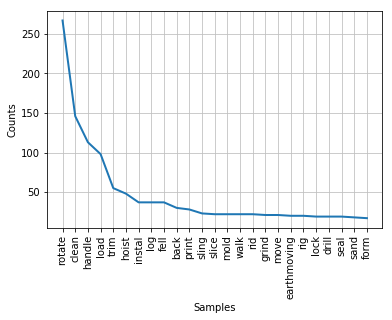

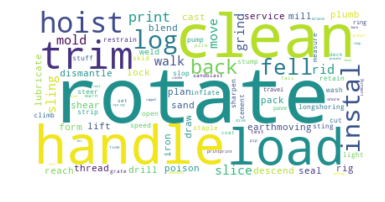

Top 3 activity word and their sentences


rotate

rotating parts hand
rotating parts work rules
rotating shaft
rotating parts
rotating parts rotating shaft
rotating shaft chain sprocket
rotating parts finger
rotating parts
rotating parts
rotating parts aircraft propeller laceration fracture inattention



clean
=====

cleaning conveyor
cleaning pump
cleaning air
cleaning air
cleaning point
cleaning air
cleaning fall struck
cleaning conveyor
cleaning rotating parts
cleaning printing machine



handle

handling auger cleaning
handling grain
handling motor vehicle
handling auger auger mechanism
handling fall
handling work rules
handling work rules
handling falling object bleach chemical burn leg
handling roller
handling lockout


Falls


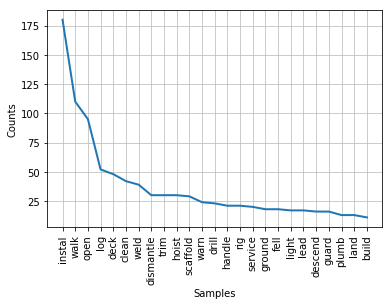

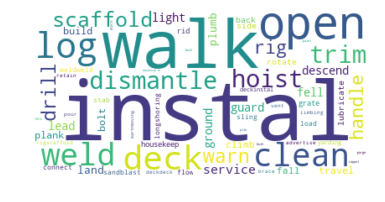

Top 3 activity word and their sentences


instal

installing ladder scaffold structure
installing arm fracture face abrasion
installing work rules
installing wrist
installing stakes
installing wall
installing skylight fall fall protection neck fracture
installing air conditioner
installing air conditioner
installing mixer blade hand tool electric drill



walk
====

walking surface
walking surface
walking backward inattention skylight
walking surface
walking backward fracture head
walking on beam
walking surface fall fracture
walking surface fall protection ppe barrier guard
walking backward construction fall fracture floor
walking surface barrier guard



open
====

opening cover ladder
opening work rules
opening fall protection fall demolition construction asbestos removal work rules
opening cover fall fracture head
opening bee sting roof
opening fall fall protection
opening maintenance ladder catwalk fall head fracture
opening ceiling panel fall protection
opening head
opening ceili

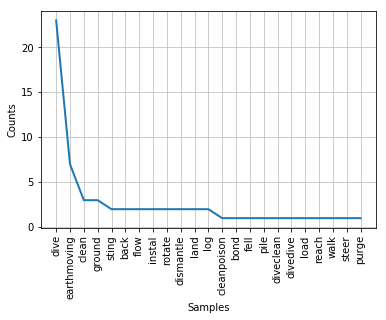

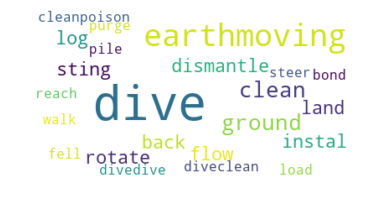

Top 3 activity word and their sentences


dive
====

diving commercial diving
diving drown scuba diving water
diving unconsciousness scuba commercial diving cpr diver water
diving cpr embolism
diving mech malfunction
diving commercial diving cpr scuba boat
diving air line swim work rules
diving gear scuba water
diving drown unconsciousness cpr
diving cpr



earthmoving

earthmoving equip equipment operator
earthmoving equip bulldozer heat exchanger pressure release
earthmoving equip bulldozer
earthmoving equip
earthmoving equip
earthmoving equip



clean
=====

cleaning poisoning skin ppe
cleaning bee
cleaning drown seizure construction water unconsciousness
cleaning seizure water drown


Other


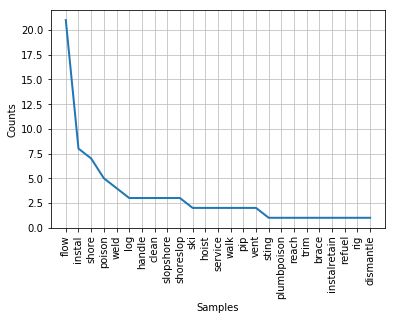

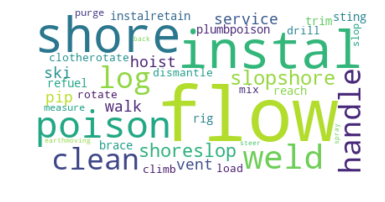

Top 3 activity word and their sentences


flow
====

flowing material
flowing material
flowing material
flowing material
flowing material
flowing material winch vibrations
flowing material safety
flowing material
flowing material work rules
flowing material



instal

installing stomach loss
installing retaining wall collapse
installing sewage wall
installing cave-in asphyxiated drain
installing pipe
installing hydraulic lift caught
installing trench box collapse
installing pipe trench trench digger
installing pipe undrgrd installation



shore
=====

shoring fall ear backhoe
shoring collapse
shoring unstable soil pipe
shoring agriculture
shoring trench box
shoring sloping trench box
shoring sloping work rules
shoring sloping unstable soil construction installing
shoring trench jacks contusion


Struck By Moving Objects


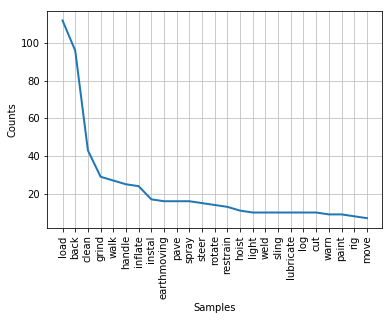

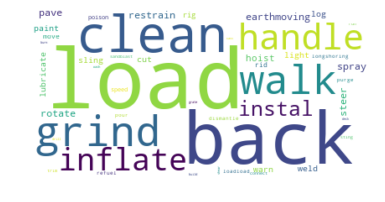

Top 3 activity word and their sentences


load
====

loading ramp loading dock
loading machinist abrasive wheel
loading trailer
loading agriculture heat heat exhaustion vomit alcohol
loading dock overturn
loading tractor trailer pallet loading dock run
loading asphalt burn
loading dock trailer truck
loading dock
loading trailer backhoe



back
====

backing up brake accelerator pedal
backing up accelerator pedal
backing up back-up alarm
backing up back-up alarm
backing up back-up alarm struck
backing up back-up alarm
backing up back-up alarm struck
backing up back-up alarm
backing up leg fracture motor vehicle
backing up back-up alarm highway road



clean
=====

cleaning repair
cleaning lighting fixture acetone
cleaning fluid tractor trailer eye
cleaning conveyor
cleaning tank paint
cleaning fluid drain
cleaning drain pipe
cleaning vacuum
cleaning combustible liquid hopper face burn
cleaning rupture


Collapse of object


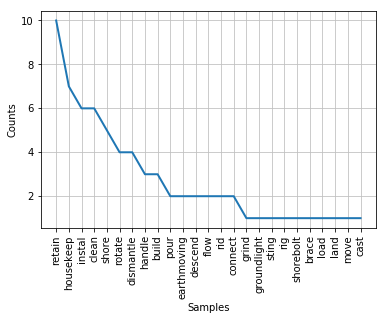

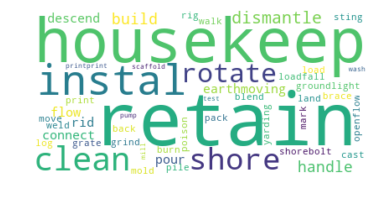

Top 3 activity word and their sentences


retain

retaining wall
retaining wall bracing collapse
retaining wall collapse alarm struck
retaining wall collapse
retaining wall
retaining wall
retaining wall lawn mower
retaining wall
retaining wall collapse cleaning demolition
retaining wall underpinning



housekeep

housekeeping allergic reaction
housekeeping vapor
housekeeping cleaning vacuum
housekeeping janitor cleaning
housekeeping amputated finger paint cleaning
housekeeping chemical arm pressure release cleaning spill
housekeeping vacuum



instal

installing industrial truck collapse
installing wall steel collapse
installing drilling mud
installing struck
installing water pipe shoring contusion leg trench
installing fracture


Fires and Explosion


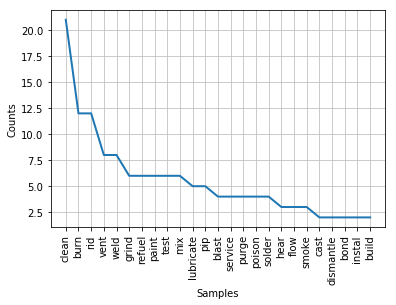

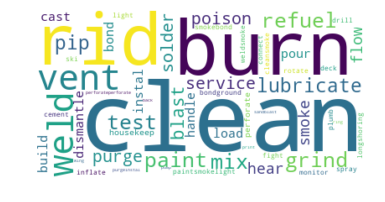

Top 3 activity word and their sentences


clean
=====

cleaning explosion fire burn work rules cleaning fluid ventilation
cleaning carbon disulfide tank
cleaning burn fire head mixer tank
cleaning fluid
cleaning coal tar
cleaning work rules
cleaning flammable vapors
cleaning laceration
cleaning process safety explosives
cleaning smoking flammable liquid



burn
====

burning naphtha fire
burning drum
burning torch oxygen propylene
burn chemical fertilizer mixing irrigation equipment water pump explosion nitrogen chest face
burning flammable liquid torch explosion burn face
burning demolition gas
burning explosion burn fire
burning work rules
burning contusion fire torch
burning torch drum



rid
===

riding on equipment
riding on equipment
riding on equipment
riding on equipment driver
riding on equipment coal car
riding on equipment horseplay highway
riding on equipment horseplay
riding on equipment slip run
riding on equipment fall head
riding on equipment


Electrocution


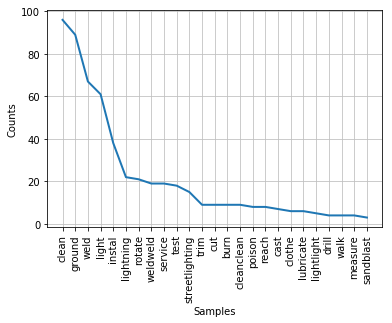

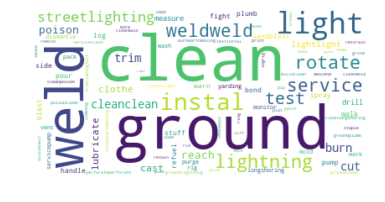

Top 3 activity word and their sentences


clean
=====

cleaning work rules
cleaning welding fire
cleaning fluid work rules
cleaning ppe work rules
cleaning tendon laceration puncture
cleaning fan fan
cleaning box lid
cleaning brush chipper milling machine guard
cleaning water tank
cleaning poisoning carbon monoxide ventilation gasoline



ground

grounding untrained e gi vii
grounding attachment plug
grounding cord
grounding conveyor
grounding electric cord attachment plug pump wet operation
grounding attachment plug
grounding elec equipment
grounding welder attachment plug e gi v
grounding electric generator
grounding cord connector attachment plug cord



weld
====

welding pipe plug pipeline excavation sump tank oxygen
welding alcohol glove hand duct
welding electric arc arc welding maintenance fire burn ppe cutting
welding welding oil drum explosion burn
welding burn arm lubricating fluid pipeline
welding welding pipe explosion
welding burn ppe clothing arc
welding burn ppe spark c

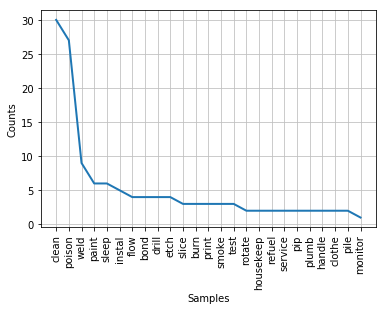

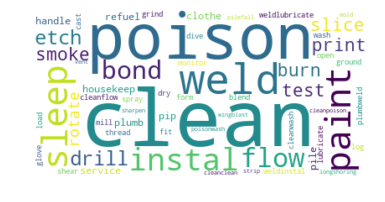

Top 3 activity word and their sentences


clean
=====

cleaning fluid lung air contamination toxic fumes
cleaning anhydrous ammonia chemical vapor chemical inhalation work rules
cleaning meat blending mach lockout machine
cleaning flammable vapors
cleaning benzene static electricity
cleaning bleach chemical reaction
cleaning fluid toxic fumes
cleaning ppe storage tank carbon disulfide
cleaning oxygen electric drill arm face
cleaning unconsciousness inhalation chemical vapor vapor ppe



poison

poisoning heat exhaustion
poisoning emergency response
poisoning inhalation ventilation
poisoning chemical vapor
poisoning chlorine gas cylinder throat cough vomit eye
poisoning chemical vapor press operator chemical
poisoning inhalation exhaust
poisoning lawn
poisoning ventilation work rules heart
poisoning exhaust fumes



weld
====

welding lubricating fluid oil tank explosion gas gas
welding protective clothing ppe toxic fumes
welding installing burn fire
welding welder explosion fire smoke 

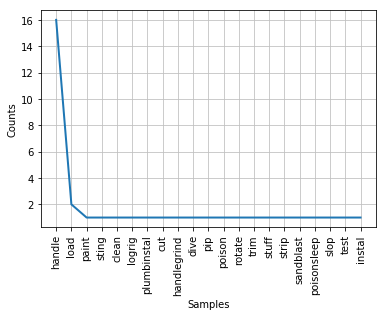

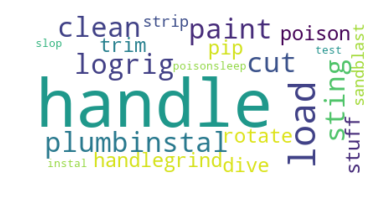

Top 3 activity word and their sentences


handle

handling baggage conveyor
handling chair sprain
handling heart
handling burn torso
handling grinding wheel equipment failure
handling fire burn
handling maintenance
handling infection shoulder
handling wheel stuck fall
handling puncture hand infection glove ppe



load
====

loading manual mat handling corn
loading allergic reaction inhalation



paint
=====

painting hexane xylene acetone lung inhalation


Exposure to extreme temperatures


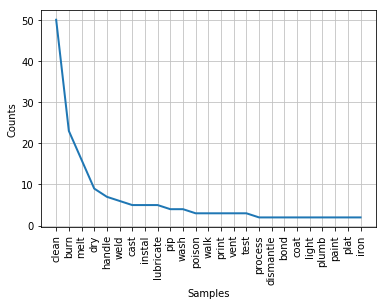

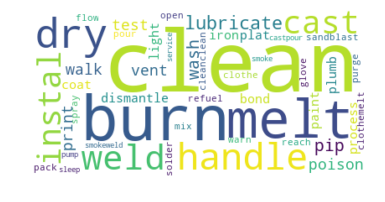

Top 3 activity word and their sentences


clean
=====

cleaning chemical burn ppe jet fuel hand
cleaning acetone fire burn
cleaning hopper coal hatch burn
cleaning maintenance
cleaning ash high temperature
cleaning work rules
cleaning burn chemical
cleaning burn
cleaning chemical burn foot ankle
cleaning disinfectant chemical burn arm



burn
====

burning torch acetylene torch burn explosion hearing loss face neck chest arm
burning leg burn fire fire extinguisher
burning flammable vapors
burning air monitoring
burning drum isopropyl alcohol explosion torch
burning torch scrap metal baler welder
burn chemical burn pressure piping pressure release
burning torch
burning fire burn clothing
burning beam fracture



melt
====

melting furnace
melting furnace jack
melting furnace explosion
melting furnace plastic mfg
melting furnace steel molten
melting furnace explosion burn
melting furnace scrap metal steel
melting furnace water chemical work rules
melting furnace furnace chemical reaction

In [68]:
if ProcessOshaDataSet:
    chunk_count = 0
    verb_count = 0
    for cat in OshaCategories:
        for chunk1 in cat.ActivityTokensChunk:
            for chunk2 in chunk1:
                if (len(chunk2) >= 1):
                    chunk_count += 1
        for verb1 in cat.ActivityTokensVerb:
            for verb2 in verb1:
                verb_count += len(verb2.split(' '))
        if (len(cat.ActivityTokensVerb) >0):
            Visualisation(cat)
    print("Osha Extraction Chunk Count is " +  str(chunk_count))
    print("Osha Extraction Verb Count is " +  str(verb_count))       

# Output to excel file with new additional columns for activity and activity chunks

In [69]:
#Write to excel with the additional columns for activity verb 
if ProcessMsiaDataSet:
    NewColumn1 = []
    NewColumn2 = []
    for item in MsiaCaseItems:
        if item.ActivityTokensVerb == []:
            NewColumn1.append("")
            NewColumn2.append("")
        else:
            NewColumn1.append(','.join(item.ActivityTokensVerb))
            NewColumn2.append(','.join(item.ActivityTokensChunk))
    MsiaCasesDF.eval("ActivityVerb = @NewColumn1", inplace=True)
    MsiaCasesDF.eval("ActivityChunk = @NewColumn2", inplace=True)
    WriteToExcel('MsiaWithActivity.xlsx',OshaCasesDF)

if ProcessOshaDataSet:
    NewColumn1 = []
    NewColumn2 = []
    for item in OshaCaseItems:
        if item.ActivityTokensVerb == []:
            NewColumn1.append("")
            NewColumn2.append("")
        else:
            NewColumn1.append(','.join(item.ActivityTokensVerb))
            NewColumn2.append(','.join(item.ActivityTokensChunk))
    OshaCasesDF.eval("ActivityVerb = @NewColumn1", inplace=True)
    OshaCasesDF.eval("ActivityChunk = @NewColumn2", inplace=True)
    WriteToExcel('OshaWithActivity.xlsx',OshaCasesDF)


# Notes and Observation: 
- For the Msia dataset which is used as training dataset, the summary columns are mostly made up of complete grammatically sound sentences and thus the regular expression parser method is chosen to extract the activity phrases.

- However, for the Osha dataset, not all sentences are complete and grammatically sound like the Msia dataset. Some of the activities descripton in the summary column are made up of just keywords instead of complete sentences thus that could result in these rows data being omitted when perform the regular expression parsing. Thus only about 5000 of the 16000 rows in which activity can be found using the parser developed in Msia dataset.

- In some sentences, for example, the actually activity is "handling maintenance work", thus the actual activity is maintenance work but because the regular expression parser is designed to extract the verb activity resulted in "handling" being captured instead of "maintaining" and results in a less than accurate description of the activity extracted from the dataset.

- Further improvements: Need to tweak the reg parser to cater for the "keywords" style description in the OSHA dataset. Some of the activities captured are actually describing the cause of the incident, thus in order to get a more accurate text mining on activities, prior domain knowledge on what is considered cause and what is activities need to be incorporated.